## Visualizing n random or representative cell in a given well
- Inputs are:
    -  **file_name** - .sql file path for the target plate(or a dataframe)
    -  **well_name** - Well name
    -  **n_cells** - number of single cells you want to visualize
    -  **box_size** - size of box in pixels for cropping a cell
    -  **channels** - list of channels you want to plot
    -  **cell_selection_method** - can be one of the following methods
        - random - generate n randomly selected cells
        - representative - clusters the data and sample from the "closest to mean cluster"
        - geometric_median - plots single sample than is the geometric median of samples
        
        
#### Steps:

- Reading the target well from the input plate 
- Sampling using cell_selection_method 
  

In [3]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import black
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY310,
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from singlecell.read import read_single_cell_sql
from singlecell.read import read_from_gallery

from singlecell.process import extract_single_cell_samples
from singlecell.visualize import visualize_n_SingleCell
from singlecell.preprocess.filter_out_edge_single_cells import edgeCellFilter
# from sklearn.cluster import KMeans
import time

DEBUG:jupyter_black:config: {'line_length': 79, 'target_versions': {<TargetVersion.PY310: 10>}}


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

In [2]:
pwd

'/home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis'

### Set paths and params

In [4]:
# file_name=\
# '/workspace/backend/2016_04_01_a549_48hr_batch1/SQ00015052/SQ00015052.sqlite'

file_name = "/workspace/backend/2016_04_01_a549_48hr_batch1/SQ00015052/SQ00015052.sqlite"

root_in_mounted_bucket = "/home/ubuntu/bucket/projects/2015_10_05_DrugRepurposing_AravindSubramanian_GolubLab_Broad"
root_in_cpgallery = "cpg0004-lincs/broad"


n_cells = 6

box_size = 100

well_name = ["A13"]

# repEnabled= True
# how we select cells which can be 'random','representative','geometric_median'
cell_selection_method = "random"

channels = ["Mito", "AGP", "DNA", "RNA", "ER"]

In [ ]:
# python restore_intelligent.py imaging-platform "projects/2015_10_05_DrugRepurposing_AravindSubramanian_GolubLab_Broad/workspace/backend/2016_04_01_a549_48hr_batch1/SQ00015195/"

### Read single cell data
- Read from s3 mounted bucket

In [5]:
%%time
df_p_s0 = read_single_cell_sql.readSingleCellData_sqlalch_well_subset(
    root_in_mounted_bucket + file_name, well_name, "Image_Metadata_Well"
)
df_p_s, _ = edgeCellFilter(df_p_s0)
print(
    "Number of cells: ",
    df_p_s0.shape[0],
    "Number of cells after edge cell removel: ",
    df_p_s.shape[0],
)

image_width 2160
Inferred edge margin: 85
Number of cells:  2164 Number of cells after edge cell removel:  1965
CPU times: user 6.66 s, sys: 4.94 s, total: 11.6 s
Wall time: 10min 42s


In [6]:
# df_p_s0[df_p_s0.columns[df_p_s0.columns.str.contains('utline')]]
# df_p_s0.columns[df_p_s0.columns.str.contains('Image_Width_OrigDNA')]
# well_name
# "select * from {}".format("Image")

#### Read from s3 gallery (in progress - not yet functional)

In [19]:
%%time
df_p_s0=read_from_gallery.read_sqlite(
                        root_in_cpgallery + file_name,\
                        wells_subset_param = [well_name,"Image_Metadata_Well"]);

df_p_s,_ = edgeCellFilter(df_p_s0);
print("Number of cells: ",df_p_s0.shape[0],"Number of cells after edge cell removel: ",df_p_s.shape[0])

In [20]:
root_in_cpgallery

'cpg0004-lincs/broad'

### Create or modify sc dataframe columns for image file names and image paths

In [7]:
#### root_dir ####
# * It can be a path to:
#     - a mounted bucket on your current machine
#     - a path to a public s3 bucket like CP gallery


paths = {
    "root_dir": "/home/ubuntu/bucket/projects/2015_10_05_DrugRepurposing_AravindSubramanian_GolubLab_Broad/",
    "batch_folder": "2016_04_01_a549_48hr_batch1_compressed",
    "outline_subdir": "/workspace/analysis/cell_outlines_Mito_Project/",
}  # for mount imaging bucket


# paths={"root_dir":root_in_cpgallery,\
#        "batch_folder": "/images/2016_04_01_a549_48hr_batch1_compressed",\
#        "outline_subdir": "/workspace/analysis/cell_outlines_Mito_Project/"
#       } # for cp gallery

meta_cols = {
    "site": "Image_Metadata_Site",
    "well": "Image_Metadata_Well",
    "plate": "Image_Metadata_Plate",
}

viz_cols = {
    "center_indicator_columns_x_y": [
        "Nuclei_Location_Center_X",
        "Nuclei_Location_Center_Y",
    ],
    "image_path_column_prefix": "PathName_Orig",
    "image_name_column_prefix": "FileName_Orig",
}

fix_paths_params = {
    "paths": paths,
    "meta_cols": meta_cols,
    "viz_cols": viz_cols,
}


def custom_create_image_path_cols(params, df_p_s):
    """
    The following columns are needed for generation of single cell images,\
    if you already have it just modify the config file,
    if not you have to generate them
    """

    paths = params["paths"]
    meta_cols = params["meta_cols"]
    viz_cols = params["viz_cols"]

    for ch in channels:
        df_p_s["PathName_Orig" + ch] = (
            paths["root_dir"]
            + paths["batch_folder"]
            + "/images/"
            + df_p_s[meta_cols["plate"]]
        )
        df_p_s["FileName_Orig" + ch] = df_p_s[
            "Image_FileName_Orig" + ch
        ].apply(lambda x: x.replace("tiff", "png"))

    df_p_s["Path_Outlines"] = (
        paths["root_dir"]
        + paths["outline_subdir"]
        + df_p_s[meta_cols["well"]]
        + "-"
        + df_p_s[meta_cols["plate"]].astype(str)
        + "/outlines/"
        + df_p_s[meta_cols["well"]]
        + "_s"
        + df_p_s[meta_cols["site"]].astype(int).astype(str)
        + "--cell_outlines.png"
    )

    return df_p_s


# single_cell_viz_config

# original_im_size=sc_df['Image_Width_OrigDNA'].values[0]

### Visualize

cp_features: 1656
cols2remove_manyNulls []
cols2remove_lowVars ['Cytoplasm_Correlation_Costes_AGP_ER', 'Nuclei_Correlation_Costes_AGP_DNA', 'Cells_Correlation_Costes_ER_DNA', 'Cytoplasm_Correlation_Costes_Mito_DNA', 'Cytoplasm_Correlation_Costes_Mito_ER', 'Nuclei_Correlation_Costes_ER_RNA', 'Nuclei_Correlation_Costes_RNA_Mito', 'Cells_Correlation_Costes_DNA_ER', 'Nuclei_Correlation_Costes_Mito_RNA', 'Nuclei_Correlation_Costes_ER_DNA', 'Nuclei_Correlation_Costes_Mito_ER', 'Cytoplasm_Correlation_Costes_RNA_DNA', 'Nuclei_Correlation_Costes_DNA_ER', 'Cells_Correlation_Costes_Mito_AGP', 'Cells_Correlation_Costes_AGP_ER', 'Nuclei_Children_Cells_Count', 'Nuclei_Correlation_Costes_Mito_DNA', 'Cytoplasm_Correlation_Costes_RNA_ER', 'Cytoplasm_Correlation_Costes_ER_DNA', 'Cells_Correlation_Costes_Mito_RNA', 'Nuclei_Correlation_Costes_ER_AGP', 'Cells_Correlation_Costes_RNA_DNA', 'Cells_Correlation_Costes_ER_RNA', 'Nuclei_Children_Cytoplasm_Count', 'Cytoplasm_Correlation_Costes_AGP_DNA', 'Cells_Cor

<IPython.core.display.Javascript object>


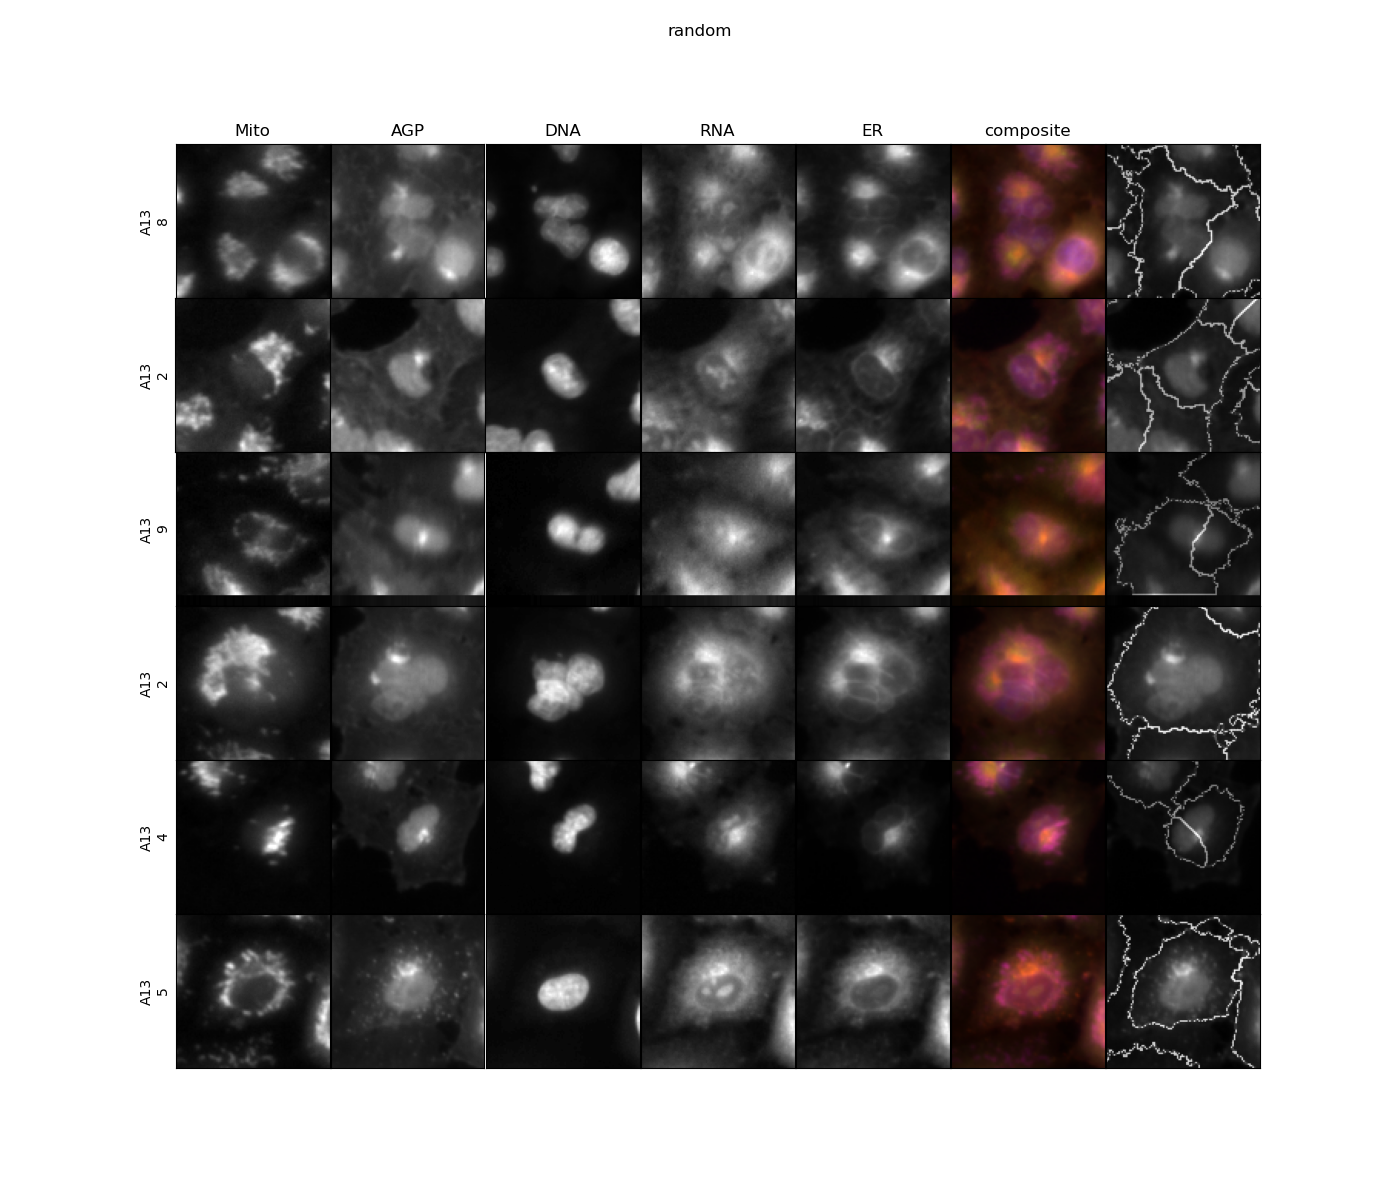

CPU times: user 4.75 s, sys: 10.1 s, total: 14.8 s
Wall time: 28.9 s


In [12]:
%%time
df_p_s = df_p_s0.copy()

# df_p_s,_ = edgeCellFilter(df_p_s0, edge_margin = int((compressed_im_size/original_im_size)*(box_size/2));
# df_p_s,_ = edgeCellFilter(df_p_s0, edge_margin = int(box_size/2));
# df_p_s,_ = edgeCellFilter(df_p_s0);


df_p_s = custom_create_image_path_cols(fix_paths_params, df_p_s)

cell_selection_method = "random"
y_labels = ["Image_Metadata_Well", "Image_Metadata_Site"]

########## extract single cell samples
(
    df_samples,
    cp_features_analysis,
) = extract_single_cell_samples.extract_single_cell_samples(
    df_p_s, n_cells, cell_selection_method
)


########## visualize single cell samples
sc_fig = visualize_n_SingleCell.visualize_n_SingleCell(
    channels,
    df_samples,
    box_size,
    info_columns=y_labels,
    outline=True,
    color=True,
    title=cell_selection_method,
    compressed=True,
    compressed_im_size=1080,
);

In [13]:
# df_samples,
df_p_s.shape,df_p_s0.shape

((2164, 2453), (2164, 2442))

In [43]:
import skimage.io
image=skimage.io.imread('/home/ubuntu/bucket/projects/2015_10_05_DrugRepurposing_AravindSubramanian_GolubLab_Broad/2016_04_01_a549_48hr_batch1_compressed/images/SQ00015052/r01c13f04p01-ch5sk1fk1fl1.png')
xCenter,yCenter=451,1035
# image_cropped = crop_single_cell_image(image,xCenter,yCenter,halfBoxSize)

In [45]:
halfBoxSize=50
im_w,im_h=image.shape;
image_cropped=image[np.maximum(yCenter-halfBoxSize,0):np.minimum(yCenter+halfBoxSize,im_w),\
                    np.maximum(xCenter-halfBoxSize,0):np.minimum(xCenter+halfBoxSize,im_h)]

In [46]:
image_cropped.shape

(95, 100)

In [30]:
np.maximum(yCenter+halfBoxSize,im_w)

1080

In [31]:
np.minimum(yCenter-halfBoxSize,0)

-42

In [37]:
image_cropped.shape

(100, 100)

In [35]:
# image_cropped.shape
np.pad(image_cropped, ((before_y_pad, after_y_pad), (before_x_pad, after_x_pad)), 'minimum').shape

(101, 101)

In [53]:
im_w,im_h=image.shape;
print(im_w,im_h)
#     image_cropped=np.zeros((halfBoxSize*2,halfBoxSize*2))
before_y_pad=0
after_y_pad=0
before_x_pad=0
after_x_pad=0

if xCenter-halfBoxSize<0:
    before_x_pad=abs(xCenter-halfBoxSize)

if yCenter-halfBoxSize<0:
    before_y_pad=abs(yCenter-halfBoxSize)

if xCenter+halfBoxSize>im_w:
    after_x_pad=abs(im_w-xCenter-halfBoxSize)

if yCenter+halfBoxSize>im_h:
    after_y_pad=abs(im_h-yCenter-halfBoxSize)

image_cropped=image[np.maximum(yCenter-halfBoxSize,0):np.minimum(yCenter+halfBoxSize,im_w),\
                    np.maximum(xCenter-halfBoxSize,0):np.minimum(xCenter+halfBoxSize,im_h)]
print('image_cropped',image_cropped.shape)
if np.max([before_y_pad, after_y_pad,before_x_pad, after_x_pad])>0:
    image_cropped=np.pad(image_cropped, ((before_y_pad, after_y_pad), (before_x_pad, after_x_pad)), 'minimum')
print('image_cropped',image_cropped.shape)


1080 1080
image_cropped (95, 100)
image_cropped (100, 100)


In [51]:
yCenter,im_h

(1035, 1080)

In [49]:
halfBoxSize

50

In [48]:
before_y_pad, after_y_pad,before_x_pad, after_x_pad

(0, 45, 0, 0)

In [ ]:
ls /home/ubuntu/bucket/projects/2015_10_05_DrugRepurposing_AravindSubramanian_GolubLab_Broad/workspace/analysis/cell_outlines_Mito_Project/A10-SQ00015195

In [ ]:
# ls /home/ubuntu/bucket/projects/2015_10_05_DrugRepurposing_AravindSubramanian_GolubLab_Broad/workspace/analysis/2016_04_01_a549_48hr_batch1_Mito_Project/SQ00015195/analysis/A10-SQ00015195/outlines/

In [ ]:
ls /home/ubuntu/bucket/projects/2015_10_05_DrugRepurposing_AravindSubramanian_GolubLab_Broad/